PoS tagging is done using a transformer model trained particularly on the Egyptian Arabic dialect. The model is called [CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-egy](https://huggingface.co/CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-egy)

In [1]:
#import torch
import pandas as pd
import numpy as np

from tqdm import tqdm

In [2]:
from transformers import pipeline

#from transformers import BertModel
# from camel_tools.disambig.mle import MLEDisambiguator
# from camel_tools.tagger.default import DefaultTagger

In [3]:
songs = pd.read_csv(
    "./data/songs.csv",
    dtype = {"Year": str}
)
print("Number of songs: ", len(songs))

Number of songs:  391


In [4]:
songs.sample(20)

,Year,Composer,Lyricist,Song,Lyrics
59,1953,منير مراد,جليل البنداري,يا دبلة الخطوبه,يا دبلة الخطوبه عقبالنا كلنا\nونبني طوبه طوبه...
347,1951,أحمد صدقي,عبد الفتاح مصطفي,مش عارفة,ايه في القلب نداني **** ايه شاغل وجداني\nاناخا...
243,1969,بليغ حمدي,عبد الرحمن الأبنودي,يا عينى عالوله,يا عيني يا عيني يا عيني عالولد\nيا عيني يا عين...
369,1953,عزت الجاهلي,فتحي قوره,كل احباء اثنين اثنين,كل احباء اثنين اثنين\nوانا وانت اجرنا عجلتين\n...
93,1973,خالد الأمير,مصطفى الضمراني,لو القلوب ارتاحو,لو القلوب ارتاحوا ....\n\nلو القلوب يا حبيبى ا...
253,1960,بليغ حمدي,فتحي قوره,اه يا سلام لو تعرف بس,اه ياسلام لوتعرف بس كنت تغني وتفرح وبس\nمين ...
260,1954,منير مراد,مصطفي عبد الرحمن,قولي بحبك,قول وانا قولك قولي بحبك\nراح تسعدني وتسعد قلبك...
142,1974,خالد الأمير,صلاح فايز,ملل,ملل.. ملل.. ملل\nحياتي ليه بقت ملل؟\nولسه أنا ...
338,1953,كارم محمود,فتحي قوره,غريبة يااهل الشام,غريبة يااهل الشام وعيون الغريب ما تنام\nدلوني ...
388,1959,منير مراد,فتحي قوره,وديني مطرح ماتوديني,وديني مطرح ماتوديني ...كل مكان وياك يرضيني\nوح...


In [5]:
lyrics = songs[["Song", "Lyrics"]]
lyrics.reset_index()
lyrics = lyrics.dropna()

In [6]:
print("Number of songs after removing empty lyrics: ", len(lyrics))

Number of songs after removing empty lyrics:  373


In [7]:
def get_max_lyrics_len():
    """
    Returns the size of the largest song.
    """
    
    return max([len(ly) for ly in lyrics["Lyrics"]])

In [8]:
L = get_max_lyrics_len()
print("Longest lyrics: ", L)

Longest lyrics:  4491


In [9]:
pos = pipeline(
    "token-classification", 
    model = "CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-egy"
)

# Extract PoS Tags

In [10]:
########################################################################################################################################################################################################################################################################################
def get_segments(ly, l = 512):
    
    S = []  # to store segments
    
    M = len(ly)  # the length of the lyrics
    n_seg = M // l

    l = l - 10 # to account for extra needed to find the next white space
    
    start = 0
    end = M
    
    i = 0
    while i < end:
        #print(i)
        j = i + l
        if j >= end:
            S.append(ly[i:end])
            break
        if ly[j] in [" ", "\n", ".", "\r"]:
            S.append(ly[i:j])
            i = j
            continue
        while j < end:
            if ly[j] in [" ", "\n", ".", "\r"]:
                S.append(ly[i:j])
                i = j
                break
            else:
                j += 1
        if j >= end:
            S.append(ly[i:end])
            break
    
    return S

########################################################################################################################################################################################################################################################################################

def extract_pos_tags():
    """
    Given the lyrics, it returns the PoS tags of all lyrics in the corpus.
    """
    

    Ly = list(lyrics["Lyrics"])
    
    PoS_tags = []
    PoS_scores = []
    
    for i, ly in enumerate(tqdm(Ly)):
        M = len(ly)
        l = 512
        seg = M // l
        T = []
        S = []
        for j in range(seg):
            T = T + pos(ly[j*l : (j+1)*l])
            
        if seg * l <= M:
            T = T + pos(ly[seg*l:])
        S = [d["score"] for d in T]
        T = [d["entity"] for d in T]
        
        PoS_tags.append(T)
        PoS_scores.append(S)
        
        
    return PoS_tags, PoS_scores
########################################################################################################################################################################################################################################################################################

In [11]:
# Now extract the PoS tags.
T, S = extract_pos_tags()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 373/373 [00:50<00:00,  7.40it/s]


In [12]:
lyrics["PoS Tags"] = T
lyrics["PoS Scores"] = S

In [13]:
lyrics.sample(30)

,Song,Lyrics,PoS Tags,PoS Scores
341,علي اخر سرعة ياعربية,علي اخر سرعة ياعربية وديني بسرعة وطير بي\nماتا...,"[prep, adj_comp, noun, noun, noun, verb, noun,...","[0.99994195, 0.9957819, 0.99992025, 0.97626185..."
238,يا ليل دق الهوا,ياليل دق الهوى بابي .. فتحت الباب لأحبابي\nلا ...,"[noun, noun, verb, noun, noun, noun, punc, pun...","[0.999456, 0.9995585, 0.9996728, 0.99974257, 0..."
249,يا دنيا زوقوكى,يادنيا زوقوكي بالعز والهناء\nيافرحة قسموكي وطو...,"[adv, noun_prop, noun_prop, noun_prop, noun_pr...","[0.64255244, 0.8780278, 0.9999058, 0.99987674,..."
369,كل احباء اثنين اثنين,كل احباء اثنين اثنين\nوانا وانت اجرنا عجلتين\n...,"[noun_quant, noun, noun, noun_num, noun_num, p...","[0.99967563, 0.99902403, 0.9989943, 0.9913168,..."
134,مصر اليوم ف عيد,مصر اليوم فى عيد\n\nياللي من البحيرة وياللي من...,"[noun_prop, noun, prep, noun, noun_prop, prep,...","[0.999913, 0.9985331, 0.9999193, 0.9996619, 0...."
390,أول لقانا,اول لقانا كان هنا ..وكان هوانا وحبنا\nفات اللي...,"[adj_num, noun, pron, verb, adv, punc, punc, v...","[0.5197998, 0.7178661, 0.8141323, 0.9998473, 0..."
263,حبايبي صبحوا عذّالي,حبايبي صبحوا عذالي وانت السبب انت ياغالي\nبتحب...,"[adj, verb, verb, noun, noun, pron, noun, pron...","[0.98495007, 0.99956876, 0.99983203, 0.9999172..."
322,انا وحبيبي,انا وحبيبي ماحدش قدي\nودنيا دي علي قده و قدي\n...,"[pron, noun, noun, noun, part_neg, noun, noun,...","[0.9997904, 0.9993013, 0.9993487, 0.99379635, ..."
206,ضربة معلّم,ضربة معلم تسلم ايده\nوربنا يقويه ويزيده.\nعرف ...,"[noun, adj, verb, noun, noun, noun, noun, verb...","[0.99994266, 0.99467516, 0.99992573, 0.9999500..."
335,احلفلك بايه,احلفلك بايه انا عمري ما غنيت وتكذبني ليه كان م...,"[noun_prop, noun_prop, prep, pron_interrog, pr...","[0.9778567, 0.993083, 0.63203293, 0.9955279, 0..."


In [14]:
def get_pos_labels():
    """
    Get the set of all possible PoS tags.
    """
    
    tags = []
    
    for t in list(lyrics["PoS Tags"]):
        tags = list(set(tags + t))

    return tags

In [15]:
tags = get_pos_labels()
print("Number of unique PoS tags: ", len(tags))

print("The set of all unique tags in the corpus are: ", tags)

Number of unique PoS tags:  30
The set of all unique tags in the corpus are:  ['pron_interrog', 'verb', 'prep', 'part', 'punc', 'part_neg', 'adv_rel', 'noun_quant', 'adj_num', 'noun', 'conj_sub', 'interj', 'part_verb', 'pron_dem', 'adj_comp', 'digit', 'conj', 'pron_rel', 'part_focus', 'adv_interrog', 'adv', 'pron', 'adj', 'abbrev', 'noun_prop', 'part_interrog', 'noun_num', 'verb_pseudo', 'part_voc', 'part_restrict']


In [16]:
# Example for sanity check.
lyrics["Lyrics"][10][:33]

' الحب الحقيقي مايتنسيش طول السنين'

In [17]:
lyrics["PoS Tags"][10][:10]

['noun', 'adj', 'verb', 'verb', 'prep', 'noun', 'noun', 'noun', 'adj', 'verb']

In [18]:
########################################################################################################################################################################################################################################################################################

def extract_feature_for_song(pos_tags, pos_scores):
    """
    Convert the given tags vector into a numerical feature vector weighted by the tags scores.
    """
    
    feature_vector = np.zeros(len(tags))
    
    for k, t in enumerate(tags): # repeat for every tag label
        idx = [i for i, p in enumerate(pos_tags) if p == t] # List comprehension
        feature_vector[k] = sum([pos_scores[i] for i in idx])
        
    return feature_vector

########################################################################################################################################################################################################################################################################################

In [19]:
extract_feature_for_song(lyrics["PoS Tags"][2], lyrics["PoS Scores"][2])

array([ 0.97244024, 54.21410951, 17.2369892 ,  0.60132241, 23.26432005,
        6.59728342,  0.        ,  0.99947852,  0.        , 68.31223372,
        2.99905872,  4.46734744,  0.        ,  4.97120041,  2.99470878,
        0.        ,  2.99284154,  7.46748632,  0.45811686,  7.95471892,
        0.49293956, 22.85108244, 31.39828357,  0.55146086, 13.78430405,
        0.        ,  0.        ,  0.        ,  4.99245936,  0.        ])

In [20]:
def extract_features_for_corpus():
    """
    Convert PoS tags to numeric feature vectors for all lyrics in
    the songs corpus.
    """
    
    feature_vectors = []
    for _, ly in lyrics.iterrows():
        feature_vectors.append(extract_feature_for_song(ly["PoS Tags"], ly["PoS Scores"]))
        
    lyrics["Feature Vector"] = feature_vectors

In [21]:
extract_features_for_corpus()

In [22]:
lyrics.sample(30)

,Song,Lyrics,PoS Tags,PoS Scores,Feature Vector
316,غاب عني ليه,غاب عني ليه..ليه ياتري***واسال عليه مين ياتري\...,"[verb, prep, adv_interrog, punc, punc, adv_int...","[0.99989104, 0.9997209, 0.9138415, 0.99991477,...","[1.9172868728637695, 27.01426202058792, 7.9945..."
220,بسبس نو الأيام عماله تحلو,س بس نو يا بس بس نو*** الايام عمالة تحلو\nشمس ...,"[conj, adv, noun_prop, part_voc, adv, conj, no...","[0.3114577, 0.77017653, 0.89170635, 0.9990398,...","[0.0, 72.51532673835754, 16.405966818332672, 0..."
66,ياهمس الحب,همس الحب يااحلي كلام **** انا سلمت قلبي وسلام\...,"[verb, noun, adj_comp, adj_comp, adj_comp, nou...","[0.9997018, 0.99988616, 0.96734077, 0.99509215...","[0.0, 51.970634043216705, 12.7713343501091, 0...."
362,الحب نصيب,الحظ نصيب والحب نصيب وهي ساعة تخيب وثانية تصيب...,"[noun, noun, noun, noun, pron, noun, verb, adj...","[0.9999362, 0.99842024, 0.9999372, 0.99883753,...","[0.986735463142395, 27.554441571235657, 9.9976..."
16,الورد ده وردهم,الورد ده وردهم والشوك هاتوه ليا\nأنا راويته له...,"[noun, pron_dem, noun, noun, noun, noun, verb,...","[0.9998493, 0.9999243, 0.9998554, 0.9972933, 0...","[0.0, 40.864950716495514, 9.698382019996643, 0..."
294,هناني هواك,هناني هواك ياشاغل بالي****ودنيا معاك راح تصفال...,"[adv, adv, noun, adj, adj, adj, noun, punc, pu...","[0.76130074, 0.36037496, 0.9995721, 0.7793221,...","[0.0, 24.761337459087372, 6.949190676212311, 0..."
142,ملل,ملل.. ملل.. ملل\nحياتي ليه بقت ملل؟\nولسه أنا ...,"[noun, punc, punc, noun, punc, punc, noun, nou...","[0.99921846, 0.9999492, 0.9999486, 0.9989882, ...","[4.921223878860474, 21.572822511196136, 1.9994..."
219,يا عنب بلدنا,\nوالله ان ما اسمريت يا عنب بلدنا\nلاجرى وانده...,"[noun_prop, conj_sub, part_neg, noun_prop, ver...","[0.95297897, 0.9994844, 0.52186847, 0.9098371,...","[0.7345388531684875, 38.74462366104126, 8.4258..."
233,احسبوا النجوم,حسبوا النجوم للعروسة في ليلة قمرية\nشبكت فيروز...,"[verb, verb, noun, noun, noun, prep, noun, adj...","[0.9998958, 0.9998857, 0.9998869, 0.9997987, 0...","[0.0, 37.05593550205231, 15.728064239025116, 0..."
126,العين ماتعلاش ع الحاجب,\nالعين ما تعلاش على الحاجب\n\n\nقدمنا له الحب...,"[noun, part_neg, noun_prop, noun_prop, prep, n...","[0.9999486, 0.9923124, 0.61938983, 0.76771975,...","[0.0, 12.64273065328598, 9.999022483825684, 0...."


# Clustering

In [23]:
M = len(lyrics)
N = len(tags)

feature_matrix = np.zeros((M, N))

print(feature_matrix.shape)

(373, 30)


In [24]:
features = list(lyrics["Feature Vector"])
print(len(features))
print(features[67])

373
[  0.          39.46216595  10.02392727   0.56144154  84.99535489
   2.30415499   0.           0.           0.         101.5005933
   6.99446404   0.           0.           1.91380101   0.
   0.           1.99937451   0.           0.           0.
   4.68945351   4.99858946  43.32236916   0.          53.66945916
   0.           0.           0.          21.98969954   0.        ]


In [25]:
for i, f in enumerate(features):
    for j in range(len(tags)):
        feature_matrix[i,j] = f[j]

In [26]:
feature_matrix.shape

(373, 30)

In [27]:
feature_matrix[10,:].shape

(30,)

In [28]:
# Check for correctness of the previous construction of the feature matrix.

assert np.array_equiv(feature_matrix[10,:], features[10])

In [29]:
assert np.array_equiv(feature_matrix[67,:], features[67])

In [30]:
assert np.array_equiv(feature_matrix[300,:], features[300])

In [31]:
lyrics.tail(30)

,Song,Lyrics,PoS Tags,PoS Scores,Feature Vector
361,الرقص جميل,علي كل لحن جميل نقوم سوي نرقص\nالرقص فن جميل ي...,"[prep, noun_quant, noun, adj, verb, noun_prop,...","[0.99993634, 0.999648, 0.99990845, 0.99989545,...","[0.0, 17.924095392227173, 3.9996771812438965, ..."
362,الحب نصيب,الحظ نصيب والحب نصيب وهي ساعة تخيب وثانية تصيب...,"[noun, noun, noun, noun, pron, noun, verb, adj...","[0.9999362, 0.99842024, 0.9999372, 0.99883753,...","[0.986735463142395, 27.554441571235657, 9.9976..."
363,سالوني ليه,سالوني ليه بتحب ليه*****وانا ذنبي ايه وياالهوي...,"[verb, verb, adv_interrog, verb, adv_interrog,...","[0.9996958, 0.9125114, 0.94152814, 0.9997955, ...","[3.9754722714424133, 33.262437522411346, 3.870..."
364,مين يسمع مني,مين يسمع مني مين ولمين راح اغني\nوانت بعيد عني...,"[pron_interrog, verb, prep, pron_interrog, pro...","[0.9602229, 0.9999224, 0.9999242, 0.869258, 0....","[5.675121247768402, 17.27556812763214, 13.9983..."
365,الدنيا مالها,الدنيا مالها النهردة مالها ******حليت في عني و...,"[noun, verb, noun, noun, noun, punc, punc, pun...","[0.9999331, 0.75239307, 0.93622136, 0.9986644,...","[0.0, 24.68175595998764, 6.999541401863098, 0...."
366,الصباوالجمال,الصباوالجمال والهوي والخيال ***وشباب والغزل قو...,"[noun_prop, noun_prop, noun, noun, noun, noun,...","[0.99401516, 0.9987457, 0.56009936, 0.98304707...","[0.0, 22.686071813106537, 3.2110084295272827, ..."
367,بغير عليك,بغير عليك من خيالك\nومن اهداب العيون\nواخاف لز...,"[verb, prep, prep, noun, noun, prep, noun, nou...","[0.969354, 0.9999267, 0.99984396, 0.9999509, 0...","[0.0, 25.367110550403595, 10.712789595127106, ..."
368,بحبك ليه,ماعرفش بحبك ليه ****وارضي بهجرك علي ليه\nيمكن ...,"[verb, verb, verb, adv_interrog, punc, punc, p...","[0.9990638, 0.7909298, 0.999762, 0.872164, 0.9...","[1.9926568269729614, 62.32428923249245, 14.794..."
369,كل احباء اثنين اثنين,كل احباء اثنين اثنين\nوانا وانت اجرنا عجلتين\n...,"[noun_quant, noun, noun, noun_num, noun_num, p...","[0.99967563, 0.99902403, 0.9989943, 0.9913168,...","[0.0, 9.997054815292358, 4.987988352775574, 0...."
370,تعالي قوام,ياحبيبي ياشاغل بالي *****وفي بعدك ليلي نهاري\n...,"[noun, adj, adj, adj, noun, punc, punc, punc, ...","[0.98266107, 0.58886266, 0.9925034, 0.99244565...","[0.0, 23.291332244873047, 14.434893071651459, ..."


In [32]:
feature_matrix[-25,:]

array([ 0.        , 22.68607181,  3.21100843,  0.        , 18.99808252,
        0.        ,  0.        ,  0.        ,  0.        , 41.56534159,
        0.99984181,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.99956673,  0.        ,  0.        ,
        0.        ,  0.        ,  4.99891055,  0.        ,  6.69055367,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

**Standardization**: Standardization scales, or shifts, the values for each numerical feature in the dataset so that the features have a mean of 0 and standard deviation of 1:

In [35]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

scaler = StandardScaler()
scaled_feature_matrix = scaler.fit_transform(feature_matrix)

scaled_feature_matrix

array([[-0.48511855, -0.00526424,  0.46559737, ..., -0.2331085 ,
        -0.08028743, -0.18262709],
       [ 0.23880853,  1.13635546,  1.27295056, ..., -0.2331085 ,
        -0.55556342, -0.18262709],
       [-0.09831906,  0.69579409,  1.05161616, ..., -0.2331085 ,
         0.23575634, -0.18262709],
       ...,
       [-0.08910864,  0.81706054,  0.5811538 , ..., -0.2331085 ,
        -0.55556342, -0.18262709],
       [ 2.67916589,  1.36989616, -0.5256121 , ..., -0.2331085 ,
        -0.55556342, -0.18262709],
       [ 0.30559795, -0.16844227, -0.8054092 , ..., -0.2331085 ,
        -0.55556342, -0.18262709]])

We will apply the kmeams clustering method. But first we want to find the optimal numbr of clusters. For this we use two criteria: (1) the Elbow curve method and (2) Silhouette Analysis. 

We start with the Elbow curve method.

## Elbow method

It is the most popular method for determining the optimal number of clusters. The method is based on calculating the Within-Cluster-Sum of Squared Errors (WSS) for different number of clusters (k) and selecting the k for which change in WSS first starts to diminish.
The idea behind the elbow method is that the explained variation changes rapidly for a small number of clusters and then it slows down leading to an elbow formation in the curve. The elbow point is the number of clusters we can use for our clustering algorithm. Further details on this method can be found in this paper by Chunhui Yuan and Haitao Yang [https://www.mdpi.com/2571-8800/2/2/16/pdf].

We will use the YellowBrick library for visualization and determination of the best value for the number of clusters $k$. It is a wrapper around Scikit-Learn.

In [72]:
from yellowbrick.cluster import KElbowVisualizer

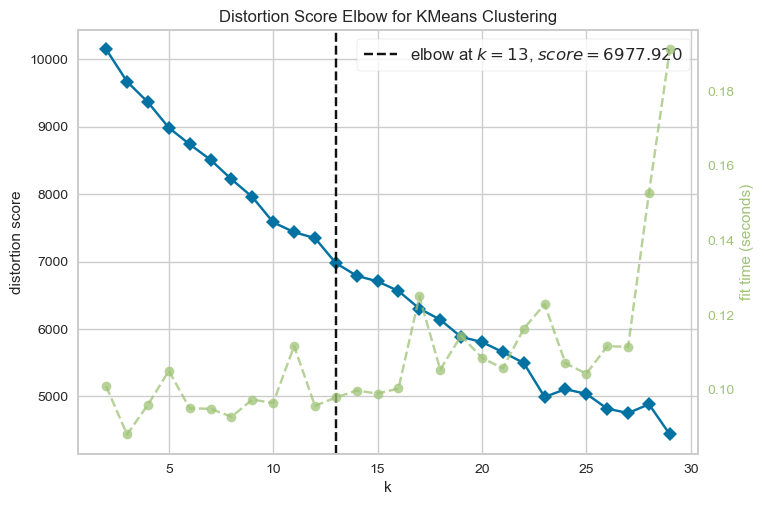

In [74]:
model = KMeans(
  init = "random",
  n_init = 30,
  max_iter = 1000
)

# k is range of number of clusters.
visualizer = KElbowVisualizer(
  model, 
  k = (2,30), # range for the possible number of clusters
  timings = True
)

visualizer.fit(scaled_feature_matrix)        # Fit data to visualizer

visualizer.show(outpath = "./figs/elbow_figure.png");        # Finalize and render figure
#savefig("./figs/elbow_figure.png", dpi = "figure");

The elbow method is run for several times. The obtained number of cluster generally varies between $10$ and $20$, however, concentrated around $15$. So, we take $k=15$ as the optimal number of clusters induced by the elbow method. We now apply another more rigorous method.

## Silhouette Coefficient

The **Silhouette Coefficient** for a point $i$ is defined as follows:

$$S(i) = \frac{b(i) - a(i)}{\max(a(i),b(i))}$$

where $b(i)$ is the smallest average distance of point $i$ to all points in any other cluster and $a(i)$ is the average distance of $i$ from all other points in its cluster. 
For example, if we have only 3 clusters A,B and C and $i$ belongs to cluster C, then $b(i)$ is calculated by measuring the average distance of $i$ from every point in cluster A, the average distance of $i$ from every point in cluster B and taking the smallest resulting value. The **Silhouette Coefficient** for the dataset is the average of the Silhouette Coefficient of individual points.

The Silhouette Coefficient tells us if individual points are correctly assigned to their clusters. We can use the following thumb rules while using Silhouette Coefficient:
$S(i)$ close to $0$ means that the point is between two clusters
If it is closer to $-1$, then we would be better off assigning it to the other clusters
If $S(i)$ is close to 1, then the point belongs to the ‘correct’ cluster
For more details on this method, please refer to this 2018 paper by N. Kaoungku, K. Suksut , R. Chanklan and K. Kerdprasop (https://www.researchgate.net/publication/323588077_The_silhouette_width_criterion_for_clustering_and_association_mining_to_select_image_features). We will be using the KElbowVisualizer function to implement Silhouette Coefficient for K-means clustering algorithm:

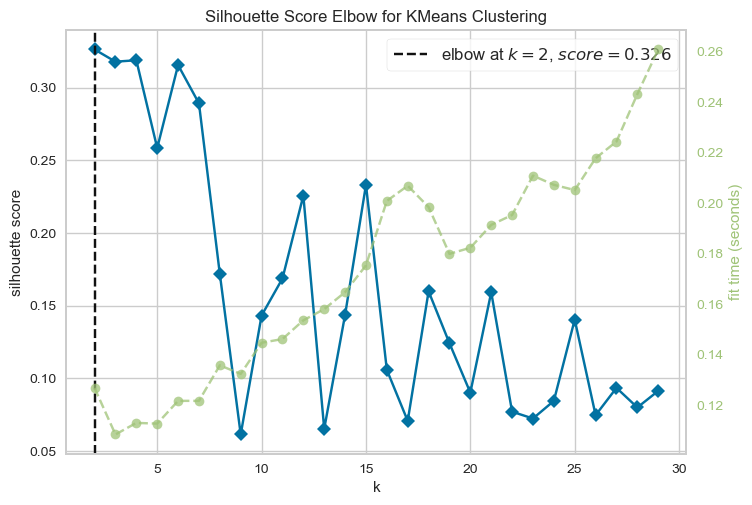

In [83]:
model = KMeans(
  #init = "random",
  n_init = 30,
  max_iter = 1000
)

# k is range of number of clusters.
visualizer = KElbowVisualizer(
  model, 
  k = (2,30), # range for the possible number of clusters
  metric = "silhouette",
  timings = True
)

visualizer.fit(scaled_feature_matrix);        # Fit data to visualizer

visualizer.show("./figs/silhouette_figure.png");        # Finalize and render figure

We have run the previous experiment several times and it always give the same result that the optimal number of clusters (according to the silhouette coefficient) is $k=2$. As the silhouette coefficient criterion is more reliable than the elbow method which is mostly vague as the elbow does not appear clear in the figure, we stick to the former method and take the number of clusters to be just $k=2$. This means that the lyrics of Shadia can only be categorized into two clusters based on the PoS tagging of the lyrics.

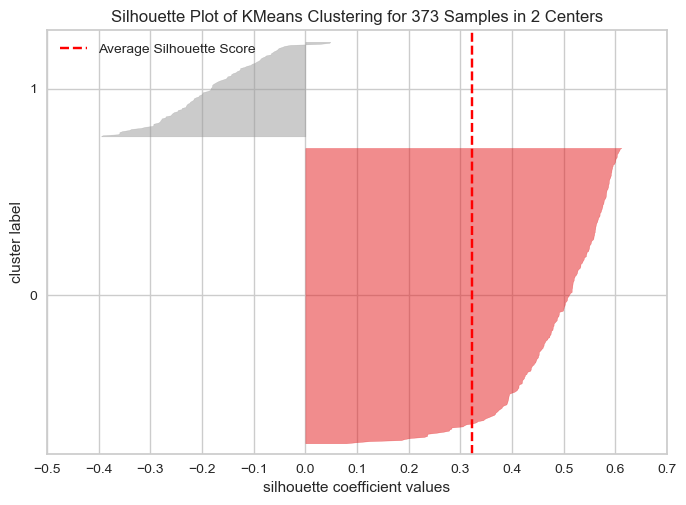

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 373 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [149]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

model = KMeans(
    2,
    n_init = 30
)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(
    scaled_feature_matrix,
)

visualizer.poof()
# visualizer.show()

In [159]:
no_clusts = 2

C = KMeans(
    init = "random",
    n_clusters = no_clusts,
    n_init = 10,
    max_iter=1000,
)

C.fit(scaled_feature_matrix)

KMeans(init='random', max_iter=1000, n_clusters=2, n_init=10)

In [188]:
N = len(lyrics)

c0 = [i for i in range(N) if C.labels_[i] == 0]
c1 = [i for i in range(N) if C.labels_[i] == 1]

y = [0] * N
for i in range(N):
    if i in c1:
        y[i] = 1

In [189]:
c1[:10]

[1, 2, 3, 5, 7, 12, 15, 17, 20, 21]

In [190]:
print(y[:10])

[0, 1, 1, 1, 0, 1, 0, 1, 0, 0]


In the following we draw the first two components of applying the pca, with the points color-coded by the corresponding cluster to which it belongs.

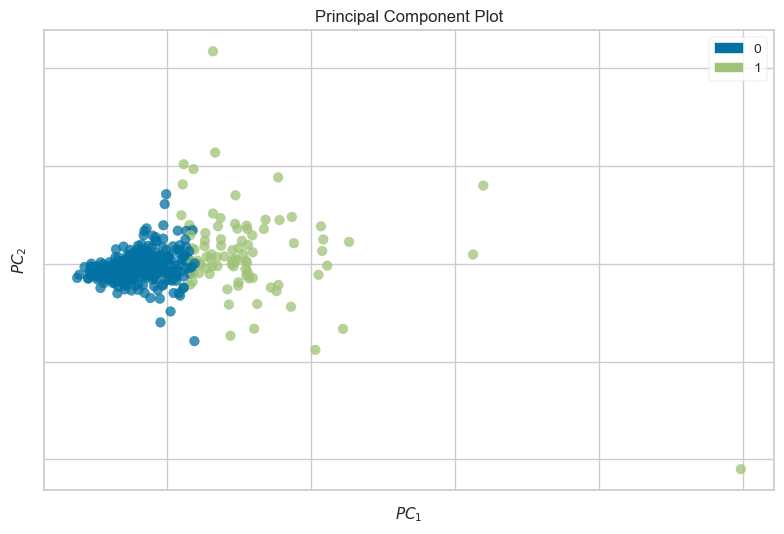

<Axes: title={'center': 'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [191]:
from yellowbrick.features.pca import PCADecomposition

visualizer = PCADecomposition(scale=True, center=False, col = y)
visualizer.fit_transform(scaled_feature_matrix, y)
visualizer.poof()

As shown the two cluster are very closed and not very well separated. That explains the above figure where the silhouette score is realtively low $0.326$. Inn addition, the precieding silhouette plot goes with negative scores till $-0.4$. So, from the perspective of PoS tagging the lyrics of Shadia are moderately diverse regarding the lingusitic structures. It is also apparent that the blue larger cluster is very much focused, unlike the second cluster which is reltively dispersed. So, this can be viewed that all of Shadia's songs are similar (wrt the PoS lingusitic structure), with some anomalies that constitute the second cluster.

In [192]:
print("Number of songs in the first cluster: ", len(c0))
print("Number of songs in the second cluster: ", len(c1))

Number of songs in the first cluster:  282
Number of songs in the second cluster:  91


In [193]:
s0 = [list(lyrics["Song"])[i] for i in range(N) if i in c_0]
s1 = [list(lyrics["Song"])[i] for i in range(N) if i in c_1]

In [200]:
import random

print("Sample songs in the first cluster (the larger blue cluster): ")
random.sample(s0, 15)

Sample songs in the first cluster (the larger blue cluster): 


['ليالى العمر معدودة',
 'الحب الحقيقي',
 'تعالى ياله',
 'احنا في جنينة',
 'علي اخر سرعة ياعربية',
 'بين ناري وجنتي',
 'يحبك اوي',
 'مصر اليوم ف عيد',
 'هدي يا دنيا',
 ' فليسقط الاستعمار  (يا بنات النيل)',
 'وحياه رب المداين',
 'ان كنت ليا',
 'فين ...هو',
 'ما ما يا حلوه',
 ' ضربة معلّم ']

In [201]:
print("Sample songs in the second cluster (the smaller green cluster): ")
random.sample(s1, 15)

Sample songs in the second cluster (the smaller green cluster): 


['زفة العروسة',
 'يا حبيبى ايوه انت بس انت',
 'غالية يا بلادي',
 'انت اول حب',
 'احلفلك بايه',
 'ادخلوها سالمين',
 'عدينا يامعاداوي',
 'يا نور عنيا',
 'تعالي أقلك',
 'ليه كل مرة',
 'حاجه غريبه',
 ' بسبس نو الأيام عماله تحلو',
 'اقوى من الزمان (لما كنا صغيرين)',
 'انا عندي مشكله',
 'صوت الجماهير']